## Selecting band comparison segments

In [1]:
import numpy as np
from PIL import Image
from glob import glob
from skimage.measure import regionprops
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import mahotas
import os

In [2]:
img_paths = sorted(glob('scenes_pca/*'))
truth_paths = sorted(glob('truth_masks/*'))
slic_paths = sorted(glob('slics/*pca.npy'))
assert len(img_paths) == len(truth_paths) == len(slic_paths)

In [3]:
# 0 - Fundo
# 1 - Desmatamento recente
# 2 - Floresta
# 3 - Ñ analisado

def is_mixed(segment):
    # flattening segment
    segment = segment.flatten()


    NFP = np.count_nonzero(segment == 2)
    NP = np.count_nonzero(segment) # desconsiderando o fundo (np.zeros)
    NNP = NP - NFP

    if NFP != 0 and NNP != 0:
        return True
    

    return False
    
def get_hor(segment):
    # flattening segment
    segment = segment.flatten()


    NFP = np.count_nonzero(segment == 2)
    NP = np.count_nonzero(segment) # desconsiderando o fundo
    NNP = NP - NFP

    HoR = max([NFP, NNP]) / NP

    return HoR

def get_major_class(segment):
    if np.argmax(np.bincount(segment.flatten())) == 2:
        return "forest"
    elif np.argmax(np.bincount(segment.flatten())) == 1:
        return "non forest"
    elif np.argmax(np.bincount(segment.flatten())) == 3:
        return "not analyzed"
    else:
        return np.argmax(np.bincount(segment.flatten()))
    
def get_region(path):
    return f"{path.split('/')[-1].split('.')[0].split('_')[-1]}"

In [4]:
segments_image_df = []
segments_truth_df = []
global_segment_array = []
global_perfect_segments = []
for idx in range(len(img_paths)):
    total_segs = 0
    good_segs = 0
    bad_by_hor = 0
    bad_by_size = 0
    n_perfect_segs = 0
    image = np.asarray(Image.open(img_paths[idx]))
    truth = np.load(truth_paths[idx])
    slic = np.load(slic_paths[idx])
    region = get_region(img_paths[idx])

    props = regionprops(slic)
    segments_truth = []
    segments_image = []
    bad_segment_ids = []
    perfect_segs_truth = []

    assert slic.shape[:2] == truth.shape[:2]
    for i, prop in enumerate(props):
        total_segs += 1
        minr, minc, maxr, maxc = prop.bbox
        segment_truth = np.zeros((maxr - minr, maxc - minc))
        segment_image = np.zeros((maxr - minr, maxc - minc, image.shape[-1]))
        coords = np.array(prop.coords)
        for pixel in coords:
            segment_truth[pixel[0] - minr, pixel[1] - minc] = truth[pixel[0], pixel[1]]
            segment_image[pixel[0] - minr, pixel[1] - minc] = image[pixel[0], pixel[1]]
        hor = get_hor(segment_truth)
        classification = get_major_class(np.uint8(segment_truth))
        if (segment_truth.shape[0] * segment_truth.shape[1] > 70) and (hor > 0.7) and (classification in ["forest", "non forest"]):
            segments_truth.append(np.uint8(segment_truth))
            segments_image.append(np.uint8(segment_image))
            segments_image_df.append({"Segment_label": prop.label, "HoR": hor, "Class": classification, "Region": region})
            segments_truth_df.append({"Segment_label": prop.label, "HoR": hor, "Class": classification, "Region": region})
            good_segs += 1
        if (hor<= 0.7):
            bad_by_hor += 1
            bad_segment_ids.append(prop.label)
        if (segment_truth.shape[0] * segment_truth.shape[1] <= 70 or classification == 0):
            bad_by_size += 1
            bad_segment_ids.append(prop.label)
        if (hor== 1):
            perfect_segs_truth.append(segment_truth)
            n_perfect_segs += 1
    global_segment_array.append(segments_truth)
    global_perfect_segments.append(perfect_segs_truth)

    print(f'{region}: total_segs = {total_segs :4d} | good_segs = {good_segs :4d} | bad_segs = {(total_segs - good_segs) :4d} | bad_segs because of HoR = {bad_by_hor :4d} | bad_segs because of size = {bad_by_size :4d} | perfect_segs = {n_perfect_segs :4d}')

    

x01: total_segs = 3551 | good_segs = 1692 | bad_segs = 1859 | bad_segs because of HoR =  181 | bad_segs because of size = 1276 | perfect_segs = 2551
x02: total_segs = 3577 | good_segs = 1249 | bad_segs = 2328 | bad_segs because of HoR =  282 | bad_segs because of size = 1273 | perfect_segs = 1991
x03: total_segs = 3482 | good_segs = 1192 | bad_segs = 2290 | bad_segs because of HoR =  356 | bad_segs because of size = 1536 | perfect_segs = 1668
x04: total_segs = 3613 | good_segs =  484 | bad_segs = 3129 | bad_segs because of HoR =  448 | bad_segs because of size = 1662 | perfect_segs = 1483
x06: total_segs = 3665 | good_segs = 1121 | bad_segs = 2544 | bad_segs because of HoR =  438 | bad_segs because of size = 1147 | perfect_segs = 1707
x07: total_segs = 3706 | good_segs = 2025 | bad_segs = 1681 | bad_segs because of HoR =  509 | bad_segs because of size = 1133 | perfect_segs = 1818
x08: total_segs = 3241 | good_segs =  964 | bad_segs = 2277 | bad_segs because of HoR =  602 | bad_segs be

In [5]:
segments_image_df = pd.DataFrame.from_records(segments_image_df)
segments_truth_df = pd.DataFrame.from_records(segments_truth_df)

In [6]:
segments_image_df.head()

,Segment_label,HoR,Class,Region
0,1,1.0,forest,x01
1,2,1.0,forest,x01
2,4,1.0,forest,x01
3,5,1.0,forest,x01
4,6,1.0,forest,x01


In [7]:
regions = segments_image_df['Region'].unique()
for region in regions:
    forest_count = segments_image_df[(segments_image_df['Region'] == region) & (segments_image_df['Class'] == 'forest')].shape[0]
    non_forest_count = segments_image_df[(segments_image_df['Region'] == region) & (segments_image_df['Class'] == 'non forest')].shape[0]
    print(f'{region}: forest = {forest_count} | non forest = {non_forest_count}')

x01: forest = 1585 | non forest = 107
x02: forest = 1115 | non forest = 134
x03: forest = 1167 | non forest = 25
x04: forest = 475 | non forest = 9
x06: forest = 1104 | non forest = 17
x07: forest = 2016 | non forest = 9
x08: forest = 928 | non forest = 36
x09: forest = 1582 | non forest = 19
x10: forest = 820 | non forest = 35


In [8]:
# segments_image_df.to_csv('segments_pca.csv', index=False)

Text(0.5, 1.0, 'Boxplot | all regions')

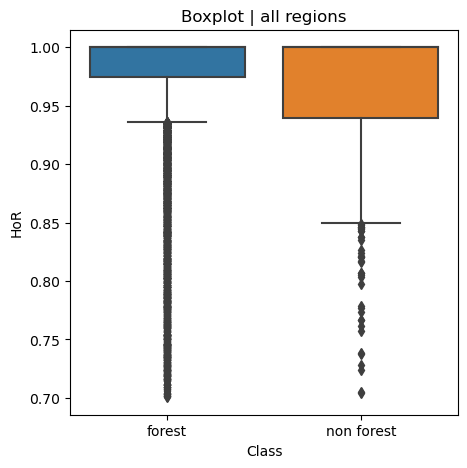

In [9]:
fig = plt.figure(figsize=(5, 5))
data = segments_truth_df
data = data.reset_index(drop=True)
ax = sns.boxplot(data, x='Class', y='HoR')
ax.set_title(f'Boxplot | all regions')


## Calculating Haralick features for every band and saving segment files

In [13]:
info = []
regions = segments_image_df['Region'].unique()
for region in regions:
    region_segments = segments_image_df[segments_image_df['Region'] == region]
    counts = region_segments['Class'].value_counts()
    
    # selecting segments
    selected_segments = region_segments.sort_values(by='HoR', ascending=False)

    ## exporting segments

    # getting labels
    forest_labels = (selected_segments[selected_segments['Class'] == 'forest'])['Segment_label'].values
    non_forest_labels = selected_segments[selected_segments['Class'] == 'non forest']['Segment_label'].values

    # loading scenes
    image = np.load(f'scenes_allbands/allbands_{region}.npy')
    slic = np.load(f'slics/slic_{region}-pca.npy')
    props = regionprops(slic)

    
    ## saving segments
    # clearing destination folder
    os.system(f'rm -r data/forest/*')
    os.system(f'rm -r data/non_forest/*')

    saved_forest = 0
    saved_nonforest = 0
    for prop in props:
        if prop.label in forest_labels:
            minr, minc, maxr, maxc = prop.bbox
            image_segment = np.zeros((maxr - minr, maxc - minc, image.shape[-1]))
            coords = np.array(prop.coords)
            for pixel in coords:
                image_segment[pixel[0] - minr, pixel[1] - minc] = image[pixel[0], pixel[1]]
            
            img = np.uint8(image_segment)
            har_bands = []

            for band in range(img.shape[-1]):
                har_forest = mahotas.features.haralick(img[:, :, band])
                har_bands.append(har_forest)
        
            img = np.stack(har_bands)

            np.save(f'data/forest/forest_{region}_{prop.label}.npy', img)
            saved_forest += 1

        if prop.label in non_forest_labels:
            minr, minc, maxr, maxc = prop.bbox
            image_segment = np.zeros((maxr - minr, maxc - minc, image.shape[-1]))
            coords = np.array(prop.coords)
            for pixel in coords:
                image_segment[pixel[0] - minr, pixel[1] - minc] = image[pixel[0], pixel[1]]
            
            img = np.uint8(image_segment)
            har_bands = []
            
            for band in range(img.shape[-1]):
                har_forest = mahotas.features.haralick(img[:, :, band])
                har_bands.append(har_forest)
        
            img = np.stack(har_bands)

            np.save(f'data/non_forest/nonforest_{region}_{prop.label}.png', img)
            saved_nonforest += 1
    info.append(dict(region=region, forest=saved_forest, nonforest=saved_nonforest, total=(saved_forest + saved_nonforest)))

In [14]:
log = pd.DataFrame.from_records(info)
log

,region,forest,nonforest,total
0,x01,1585,107,1692
1,x02,1115,134,1249
2,x03,1167,25,1192
3,x04,475,9,484
4,x06,1104,17,1121
5,x07,2016,9,2025
6,x08,928,36,964
7,x09,1582,19,1601
8,x10,820,35,855


In [15]:
log.sum()

region       x01x02x03x04x06x07x08x09x10
forest                             10792
nonforest                            391
total                              11183
dtype: object